In [7]:
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import fiona
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy import stats 
import time

## Get level 1 admin units (federal states) shapefile

In [2]:
shapefile_path = 'data/shapefiles/GDL Shapefiles V4.shp'
shapes_NGA = {}

with fiona.open(shapefile_path) as shapefile:
    for feature in shapefile:
        if feature['properties']['country'] == 'Nigeria':
            shapes_NGA[feature['properties']['GDLcode']] = feature['geometry']

## Read dataframe from csv file

In [3]:
df = pd.read_csv('data/results/hdi-threshold-metrics.csv', index_col=[0,1])
df

HDI  balanced accuracy        F1  precision    recall
0 NGAr101  0.604           0.753094  0.628949   0.721739  0.557300
  NGAr102  0.656           0.821794  0.758712   0.852365  0.683602
  NGAr103  0.426           0.653447  0.382385   0.460529  0.326914
  NGAr104  0.622           0.836424  0.732382   0.790166  0.682474
  NGAr105  0.598           0.647326  0.408369   0.543730  0.326970
...          ...                ...       ...        ...       ...
8 NGAr133  0.611           0.512688  0.049521   0.989295  0.025396
  NGAr134  0.410           0.511229  0.043957   0.968829  0.022489
  NGAr135  0.574           0.508829  0.034719   0.974474  0.017674
  NGAr136  0.415           0.507413  0.029246   0.924429  0.014858
  NGAr137  0.640           0.525544  0.097374   0.928097  0.051382

[333 rows x 5 columns]

## Compute correlation factor for all metrics for all thresholds

In [4]:
thresholds = np.arange(9)

In [5]:
metrics = df.columns.to_numpy()[1:]
metrics

array(['balanced accuracy', 'F1', 'precision', 'recall'], dtype=object)

In [8]:
data = np.vstack([df[['HDI', metric]]
                   .groupby(level=0)
                   .apply(lambda x: stats.spearmanr(x['HDI'], x[metric])[0])
                   .to_numpy()
                   for metric in metrics]).T

In [9]:
df_spearman = pd.DataFrame(index=thresholds, data=data, columns=metrics)
df_spearman

,balanced accuracy,F1,precision,recall
0,0.686588,0.786316,0.827938,0.713151
1,0.631922,0.682557,0.757382,0.632752
2,0.529112,0.592553,0.718250,0.540851
3,0.468991,0.498992,0.674967,0.478359
4,0.403415,0.427013,0.611645,0.423930
5,0.357287,0.367248,0.534211,0.358591
6,0.333215,0.333808,0.508479,0.333808
7,0.293134,0.296810,0.484169,0.296810
8,0.244160,0.245583,0.300961,0.245583


In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6))

for ax,metric in zip(axes.ravel(),metrics):
    ax.scatter(thresholds, df_spearman[metric], marker='+')
    ax.set_title(metric)

axes[0][0].set_ylabel('spearmanr')
axes[1][0].set_ylabel('spearmanr')
axes[1][0].set_xlabel('threshold')
axes[1][1].set_xlabel('threshold')
fig.suptitle('correlation with HDI')
#fig.tight_layout()
plt.show()

## Make plots for threshold = 3

In [ ]:
labels = pd.read_csv('data/results/region_codes.csv', index_col=['GDLCODE'])

NameError: name 'labels' is not defined

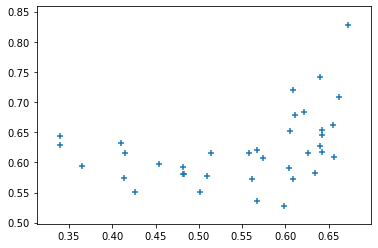

In [11]:
import matplotlib.pyplot as plt

x = df.loc[3,'HDI']
y = df.loc[3,'balanced accuracy']
region_codes = df.loc[3].index.to_numpy()

plt.scatter(x, y, marker='+', label='data')

# annotate extreme examples
for i,(x_,y_) in enumerate(zip(x,y)):
    if x_ == np.max(x):
        plt.annotate(labels.loc[region_codes[i]][0], (x_-0.02, y_+0.01))
    elif x_ == np.min(x):
        plt.annotate(labels.loc[region_codes[i]][0], (x_+0.004, y_+0.004))
    if y_ == np.max(y):
        pass # because Lagos again
        #plt.annotate(labels.loc[region_codes[i]][0], (x_-0.02, y_+0.01))
    elif y_ == np.min(y):
        plt.annotate(labels.loc[region_codes[i]][0], (x_+0.002, y_+0.005))

plt.ylabel('balanced accuracy')
plt.xlabel('HDI')
plt.title('Level 1 admin units of Nigeria (threshold = 3)')
#plt.legend()

plt.show()

In [18]:
df_score = df.loc[3]
df_score.min(axis=0)


HDI                  0.339000
balanced accuracy    0.528291
F1                   0.108381
precision            0.781992
recall               0.057971
dtype: float64

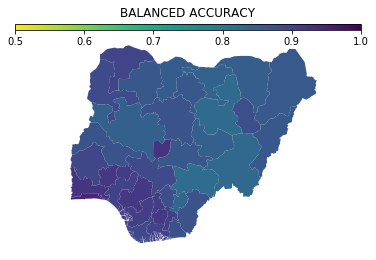

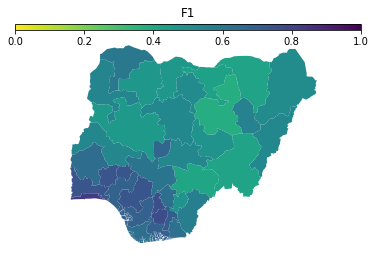

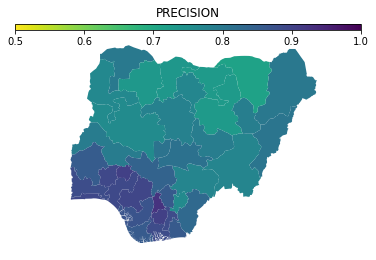

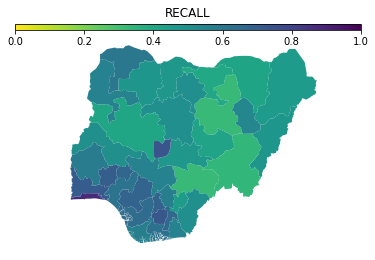

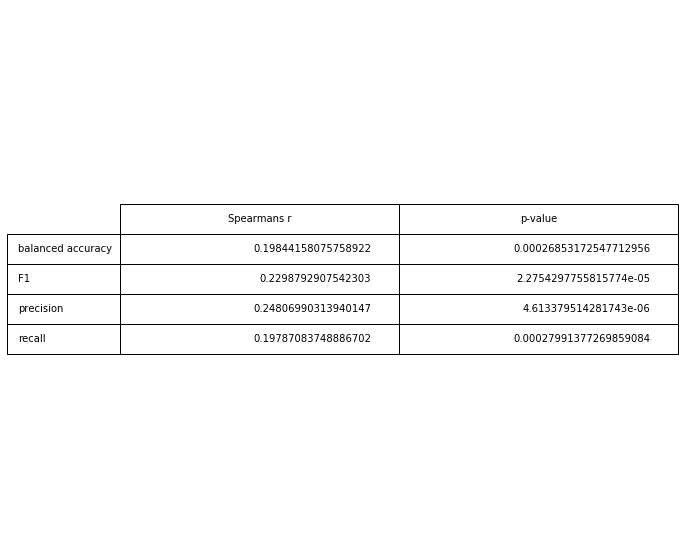

In [16]:
import matplotlib.pyplot as plt
import matplotlib
from shapely.geometry import shape
import shapely
from scipy import stats 

def plot_whole_country(shapes_NGA, metric_title, metric_per_region):
    cmap = matplotlib.cm.get_cmap('viridis_r')
    if(np.logical_or(metric_title=='balanced accuracy', metric_title=='precision')):
        norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.0)
    else:
        norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
    fig, ax = plt.subplots()
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    for gdl_code, geo in shapes_NGA.items():
        shapely_geometry = shape(geo)
        if(isinstance(shapely_geometry, shapely.geometry.multipolygon.MultiPolygon)):
            ax.set_aspect('equal', 'datalim')
            for geom in shapely_geometry.geoms:
                x, y = geom.exterior.xy
                metric = metric_per_region[gdl_code]
                color = cmap(metric)
                ax.fill(x, y, facecolor=color)
        else:
            x, y = shapely_geometry.exterior.xy
            metric = metric_per_region[gdl_code]
            color = cmap(metric)
            ax.fill(x, y, facecolor=color)
    fig.suptitle(metric_title.upper())
    ax2 = fig.add_axes([0.10, 0.9, 0.8, 0.02])
    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
    plt.show()

cols = ['balanced accuracy', 'F1', 'precision', 'recall']
correlation = []
for col in cols:
    metric_per_region = dict(zip(df_score.index, df.loc[:, col]))
    plot_whole_country(shapes_NGA, col, metric_per_region)

    cr, pval = stats.spearmanr(df['HDI'], df.loc[:, col])
    correlation.append((cr, pval))

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=correlation , rowLabels=cols, colLabels=['Spearmans r', 'p-value'], loc='center')
fig.set_size_inches(10, 10)
plt.show()